# Unsupervised Learning
# Project on "BIRCH: An Efficient Data Clustering Method for Very Large Databases"

* [Introduction](#intro)
* [Pros of the BIRCH algorithm presented in the paper](#pro)
* [Implementation of BIRCH](#implementation)
* [Comments on the results](#comments)
* [Possible improvements](#improvements)

## Introduction <a class="anchor" id="intro"></a>

In this notebook I developed a first implementation of the BIRCH algorithm described in the paper "BIRCH: An Efficient Data Clustering Method for Very Large Databases". The implementation has been tested on the `iris` toy dataset.

Load the required packages, get the `iris` dataset and see how it is built:

In [35]:
from sklearn import datasets # to get the iris dataset
import matplotlib.pyplot as plt
import numpy as np
import os
import copy

import CFTree_methods # local file
import side_methods # local file

iris = datasets.load_iris()

# Print the contents of the iris dataset
print("Keys of iris dataset:", iris.keys)
print("\nDescription of dataset:\n", iris.DESCR)
print("\nFeature names:", iris.feature_names) # type: <class 'list'>; len(iris.feature_names) is 4; iris.feature_names[0] contains a string
print("\nTarget names:", iris.target_names) # type: <class 'numpy.ndarray'>; shape: (3,); iris.target_names[0] contains a string
print("\nFirst 5 rows of data:\n", iris.data[:5]) # iris.data has type: <class 'numpy.ndarray'>; shape: (150, 4)
print("\nFirst 5 target values:", iris.target[:5]) # iris.taget has type: <class 'numpy.ndarray'>; shape: (150,)

Keys of iris dataset: <built-in method keys of Bunch object at 0x0000019D5255C9B0>

Description of dataset:
 .. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    pet

Define a couple of methods useful to visualise the points:

In [2]:
def plot2D_iris(data_x, name_x, data_y, name_y, target, colors_on, predict_on, name_image, base_path = r"C:\Users\Gaia\Desktop\BIRCH\data"):
    '''
    target: list of indeces. Datapoint i belongs to the target[i] cluster
    colors_on: should the point be colored depending on the cluster they are associated?
    predict_on: am I using clusters that are not given by the ground truth?
    name_image: if it is not None, will save the image with this name
    '''
    _, ax = plt.subplots()
    if colors_on == True and predict_on == False:
        colors = ['red', 'green', 'blue']
    elif colors_on == False and predict_on == False:
        colors = ['grey', 'grey', 'grey']
    else: # if predict_on == True
        colors = ['pink', 'orange', 'cyan']
    
    cmap = plt.cm.colors.ListedColormap(colors)
    scatter = ax.scatter(data_x, data_y, c=target, cmap=cmap)
    ax.set(xlabel=name_x, ylabel=name_y)

    if colors_on == True and predict_on == False:
        show = ax.legend(
            scatter.legend_elements()[0], iris.target_names, loc="lower right", title="Classes"
        )
    else: # (colors_on == False and predict_on == False) or predict_on == True
        invisible_handles = [plt.Line2D([0], [0], color='w') for _ in iris.target_names]
        noShow = ax.legend(
            invisible_handles, iris.target_names, loc="lower right", title="Classes"
        )

    if name_image is not None:
        if predict_on:
            base_path = os.path.join(base_path, "results")
        plt.savefig(os.path.join(base_path, name_image))


def plot3D_iris(data_x_num, name_x_num, data_x_den, name_x_den, data_y_num, name_y_num, data_y_den, name_y_den, data_z, name_z, target, colors_on, predict_on, name_image, base_path = r"C:\Users\Gaia\Desktop\BIRCH\data"):
    '''
    target: list of indeces. Datapoint i belongs to the target[i] cluster
    colors_on: should the point be colored depending on the cluster they are associated?
    predict_on: am I using clusters that are not given by the ground truth?
    name_image: if it is not None, will save the image with this name
    '''
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    x = data_x_num / data_x_den  # first feature
    y = data_y_num / data_y_den  # second feature
    z = data_z # third feature  

    if colors_on == True and predict_on == False:
        colors = ['red', 'green', 'blue']
    elif colors_on == False and predict_on == False:
        colors = ['grey', 'grey', 'grey']
    else: # if predict_on == True
        colors = ['pink', 'orange', 'cyan']

    cmap = plt.cm.colors.ListedColormap(colors)
    scatter = ax.scatter(x, y, z, c=target, cmap=cmap)

    ax.set_xlabel(f"{name_x_num} / {name_x_den}", labelpad=5)
    ax.set_ylabel(f"{name_y_num} / {name_y_den}", labelpad=5)
    ax.set_zlabel(name_z, labelpad=5)

    legend_labels = iris.target_names
    legend_handles = []

    if colors_on == True and predict_on == False:
        for i in range(len(legend_labels)):
            handle = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10)
            legend_handles.append(handle)
    else:  # (colors_on == False and predict_on == False) or predict_on == True
        for i in range(len(legend_labels)):
            handle = plt.Line2D([0], [0], marker='o', color='w')
            legend_handles.append(handle)

    ax.legend(legend_handles, legend_labels, title="Classes", loc="upper right")
    ax.view_init(40, 10)

    if name_image is not None:
        if predict_on:
            base_path = os.path.join(base_path, "results")
        plt.savefig(os.path.join(base_path, name_image))

    plt.show()

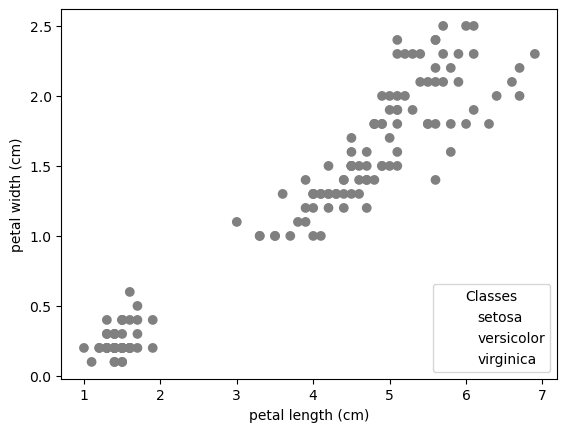

In [3]:
feature_x = 2
feature_y = 3

plot2D_iris(data_x = iris.data[:, feature_x], name_x = iris.feature_names[feature_x], data_y = iris.data[:, feature_y], name_y = iris.feature_names[feature_y],
            target = iris.target, colors_on = False, predict_on = False, name_image = "iris_2D_1.jpg")


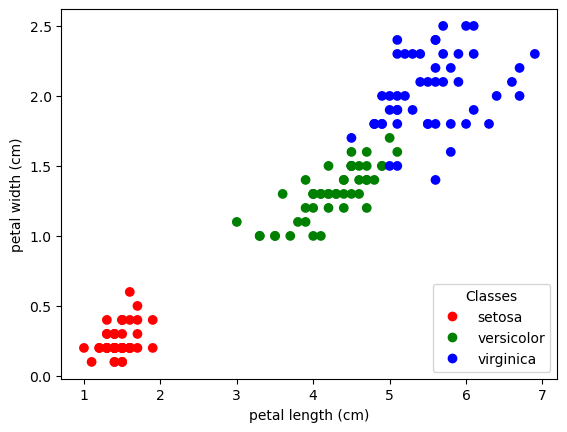

In [4]:
feature_x = 2
feature_y = 3

plot2D_iris(data_x = iris.data[:, feature_x], name_x = iris.feature_names[feature_x], data_y = iris.data[:, feature_y], name_y = iris.feature_names[feature_y],
            target = iris.target, colors_on = True, predict_on = False, name_image = "iris_2D_2.jpg")


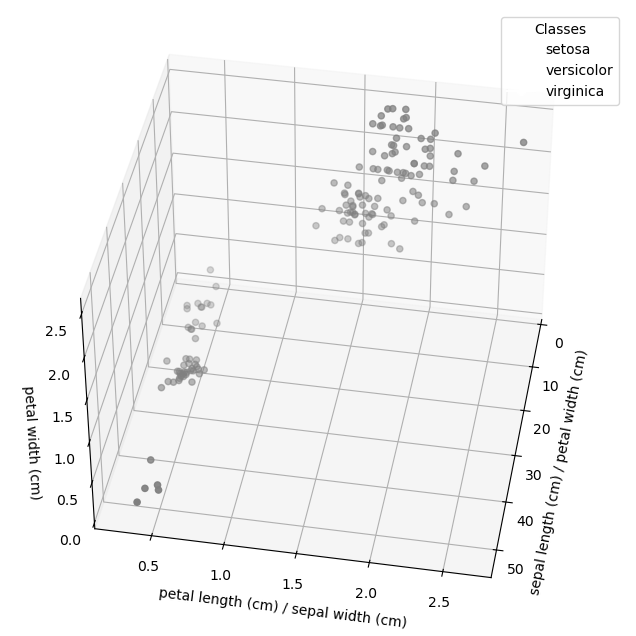

In [5]:
feature_x_num = 0
feature_x_den = 3
feature_y_num = 2
feature_y_den = 1
feature_z = 3

plot3D_iris(data_x_num = iris.data[:, feature_x_num], name_x_num = iris.feature_names[feature_x_num], data_x_den = iris.data[:, feature_x_den], name_x_den = iris.feature_names[feature_x_den], 
            data_y_num = iris.data[:, feature_y_num], name_y_num = iris.feature_names[feature_y_num], data_y_den = iris.data[:, feature_y_den], name_y_den = iris.feature_names[feature_y_den],
            data_z = iris.data[:, feature_z], name_z = iris.feature_names[feature_z], target = iris.target, colors_on = False, predict_on = False, name_image = "iris_3D_1.jpg")


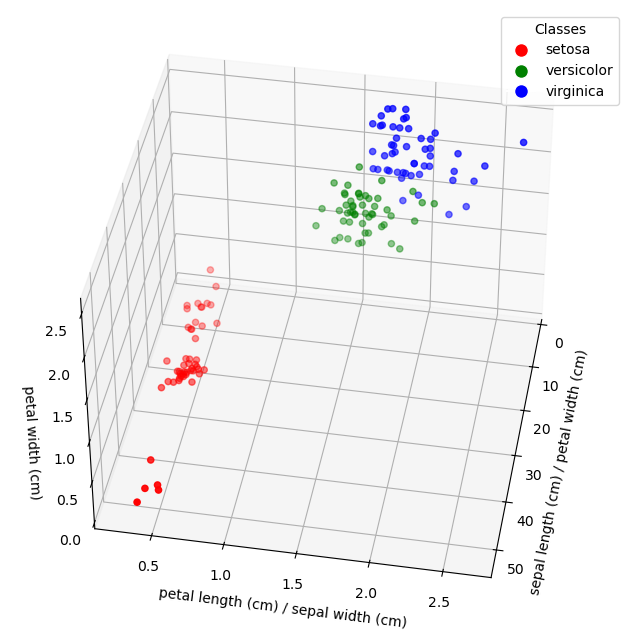

In [6]:
feature_x_num = 0
feature_x_den = 3
feature_y_num = 2
feature_y_den = 1
feature_z = 3

plot3D_iris(data_x_num = iris.data[:, feature_x_num], name_x_num = iris.feature_names[feature_x_num], data_x_den = iris.data[:, feature_x_den], name_x_den = iris.feature_names[feature_x_den], 
            data_y_num = iris.data[:, feature_y_num], name_y_num = iris.feature_names[feature_y_num], data_y_den = iris.data[:, feature_y_den], name_y_den = iris.feature_names[feature_y_den],
            data_z = iris.data[:, feature_z], name_z = iris.feature_names[feature_z], target = iris.target, colors_on = True, predict_on = False, name_image = "iris_3D_2.jpg")


## Pros of the BIRCH algorithm presented in the paper <a class="anchor" id="pro"></a>

Main pros offered by the BIRCH algorithm, and mentioned in the paper:

- especially suitable for large datasets

- makes full use of available memory to derive the finest possible subclusters (to ensure accuracy) while minimizing I/O costs 

- omitting the optional Phase 4, it does not require the whole dataset in advance, and only scans the dataset once. Each clustering decision is made without scanning all data points or all currently existing clusters. Can typically find a good clustering with a single scan of the data

- the first clustering algorithm proposed in the database area to handle "noise"

- architecture also offers opportunities for parallelism

- exploits the observation that the data space is usually not uniformly occupied, and hence not every data point is equally important for clustering purposes


## Implementation of BIRCH <a class="anchor" id="implementation"></a>

### Phase 1

**Caveats**:

- the algorithm for insertion in the CF tree is given by the section "4.2 Insertion into a CF Tree", but the step of "merging refinement" mentioned in the paper has not been implemented
- I assume I have enough memory to store the tree with the given parameters: therefore, I do not need the steps described in the section "5.1 Phase 1 Revisited"

In [17]:
#
# Phase 1: Load into memory by building a CF tree
#

branching_factor_B_test = 3
threshold_T_test = 0.05
max_num_entries_leafnode_L_test = 2

tree_test = CFTree_methods.CFTree(branching_factor_B_test, threshold_T_test, max_num_entries_leafnode_L_test, distance_metric = side_methods.average_intercluster_distance_D2)

for i in range(len(iris.data)):
    tree_test.insert(iris.data[i])

print("\n\nDISPLAYING CF TREE:\n")
CFTree_methods.display_tree(tree_test.root)



DISPLAYING CF TREE:

Depth 0: Internal Node:
  N: 150
  LS: [876.5 458.6 563.7 179.9]
  SS: 9539.29

  Child 0:
    Depth 1: Internal Node:
      N: 52
      LS: [260.2 175.8  79.9  14.3]
      SS: 2049.52

      Child 0:
        Depth 2: Internal Node:
          N: 25
          LS: [118.5  76.8  38.7   6.6]
          SS: 873.0400000000001

          Child 0:
            Depth 3: Internal Node:
              N: 5
              LS: [22.  14.4  6.4  1. ]
              SS: 147.22

              Child 0:
                Depth 4: Internal Node:
                  N: 5
                  LS: [22.  14.4  6.4  1. ]
                  SS: 147.22

                  Child 0:
                    Depth 5: Internal Node:
                      N: 1
                      LS: [4.5 2.3 1.3 0.3]
                      SS: 27.32

                      Child 0:
                        Depth 6: Leaf Node:
                          N: 1
                          LS: [4.5 2.3 1.3 0.3]
                          

Collect data with different parameters. The `list_trees` will store the data; it is a list of elements in the form: `[branching_factor_B, threshold_T, max_num_entries_leafnode_L, tree]`:

In [78]:
list_trees = [] # list of lists in the form: [branching_factor_B, threshold_T, max_num_entries_leafnode_L, tree]

list_branching_factor_B = [2, 3, 4]
list_threshold_T = [0.01, 0.05, 0.1]
list_max_num_entries_leafnode_L = [2, 3, 4]

for branching_factor_B in list_branching_factor_B:
    for threshold_T in list_threshold_T:
        for max_num_entries_leafnode_L in list_max_num_entries_leafnode_L:

            tree = CFTree_methods.CFTree(branching_factor_B, threshold_T, max_num_entries_leafnode_L, distance_metric = side_methods.average_intercluster_distance_D2)
            for i in range(len(iris.data)):
                tree.insert(iris.data[i])

            list_trees.append([branching_factor_B, threshold_T, max_num_entries_leafnode_L, tree])


In [39]:
# # To see the content of list_trees

# tree_index = 6
# print(list_trees[tree_index])
# print("\n")
# print(CFTree_methods.display_tree(list_trees[tree_index][3].root))

### Phase 2

In [40]:
#
# Phase 2: Condense into desirable range by building a smaller CF tree
#

# NOT IMPLEMENTED

### Phase 3

Collect data with different parameters. The `list_result_clusters` will store the data; it is a list of elements in the form: `[branching_factor_B, threshold_T, max_num_entries_leafnode_L, result_clusters]`:

In [49]:
#
# Phase 3: Global Clustering
#

# Use agglomerative hierarchical clustering algorithm by applying it directly to the subclusters represented by their CF vectors; use D2 distance metric

list_result_clusters = [[row[i] for i in range(len(row)) if i != 3] for row in list_trees] # will be a list of [branching_factor_B, threshold_T, max_num_entries_leafnode_L, result_clusters]

for index in range(len(list_result_clusters)):

    # Get the list list_leafnodes of the leafnodes and the list list_subclusters containing all the subclusters (each subcluster is a collection of datapoints)
    a_leafnode = list_trees[index][3].get_a_leafnode()
    list_leafnodes = []
    list_leafnodes.append(a_leafnode)

    list_subclusters = []
    for subcluster_i in range(len(a_leafnode.CF_list)):
        list_subclusters.append(a_leafnode.CF_list[subcluster_i])

    # Get all the prev leafnodes
    current_leafnode = a_leafnode
    while current_leafnode.pointer_prev is not None:
        current_leafnode = current_leafnode.pointer_prev
        list_leafnodes.append(current_leafnode)
        for subcluster_i in range(len(current_leafnode.CF_list)):
            list_subclusters.append(current_leafnode.CF_list[subcluster_i])
        
    # Get all the next leafnodes
    current_leafnode = a_leafnode
    while current_leafnode.pointer_next is not None:
        current_leafnode = current_leafnode.pointer_next
        list_leafnodes.append(current_leafnode)
        for subcluster_i in range(len(current_leafnode.CF_list)):
            list_subclusters.append(current_leafnode.CF_list[subcluster_i])

    # Here list_subclusters is a list made of elements [CF, Subcluster]. It contains all the subclusters from the CFTree

    # Get result_clusters, a dictionary where the key indicates the index of the cluster and the value is an array of the associated datapoints
    num_clusters = 3
    result_clusters = side_methods.hierarchical_clustering(list_subclusters, num_clusters)

    list_result_clusters[index].append(result_clusters)


Get and save the images in 2D and 3D:

C:\Users\Gaia\AppData\Local\Temp\ipykernel_25536\1445409170.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, ax = plt.subplots()


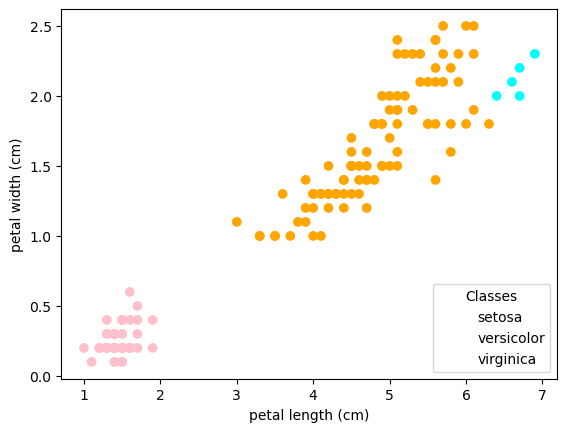

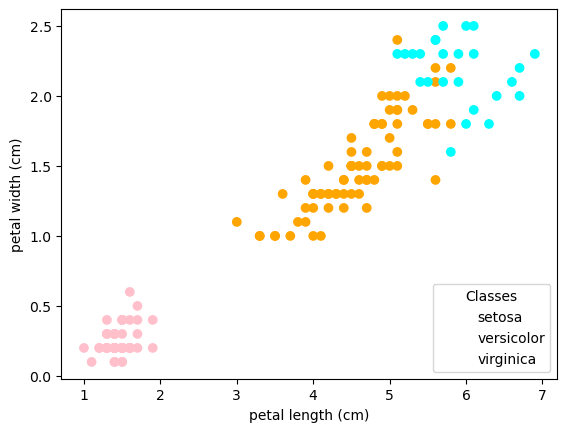

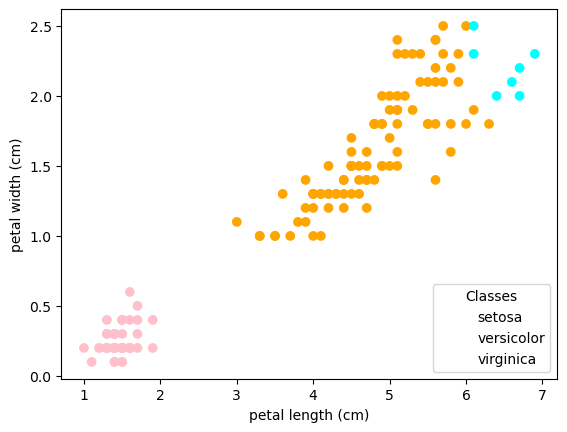

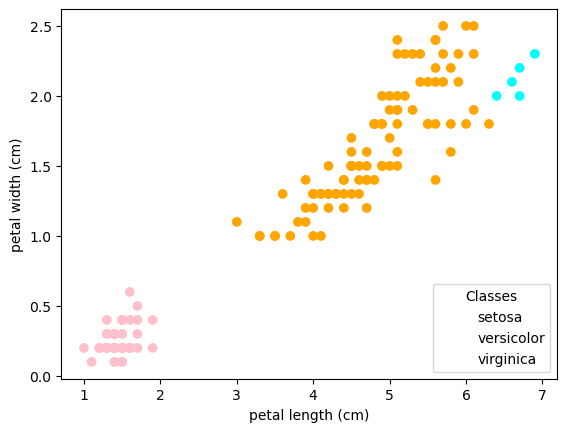

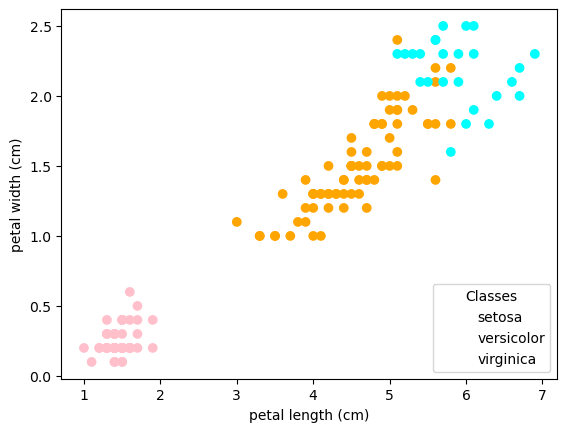

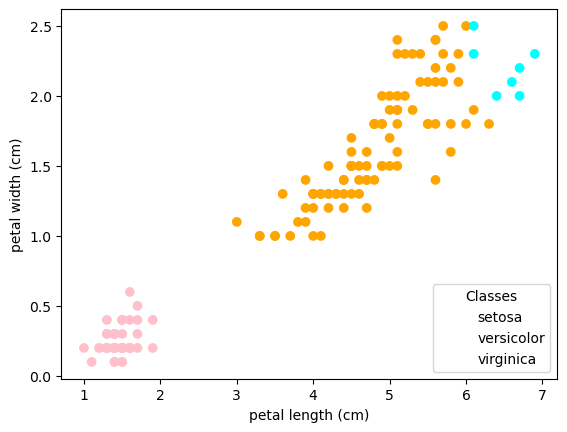

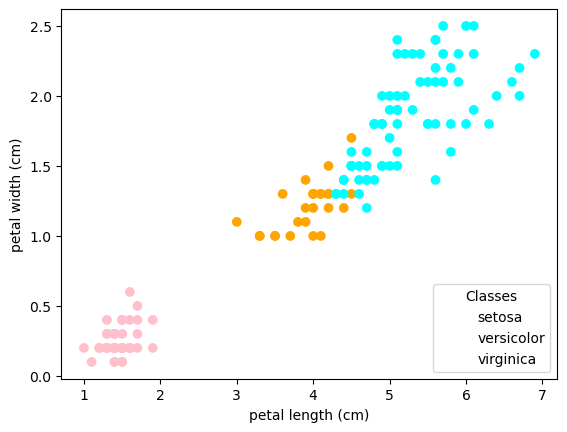

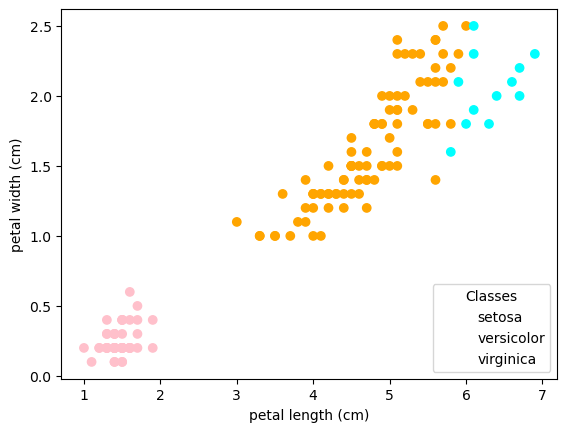

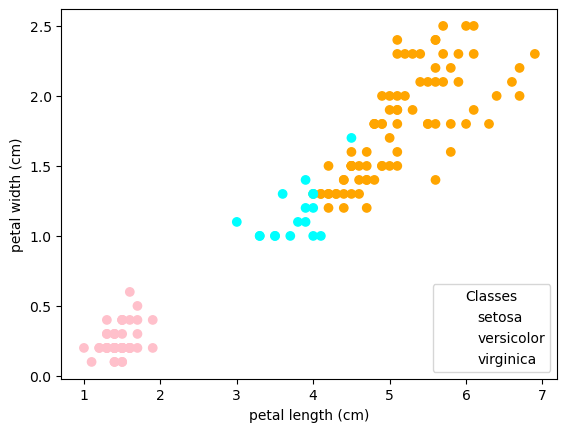

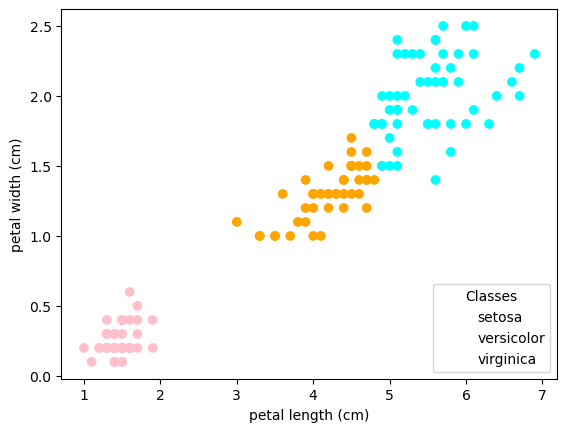

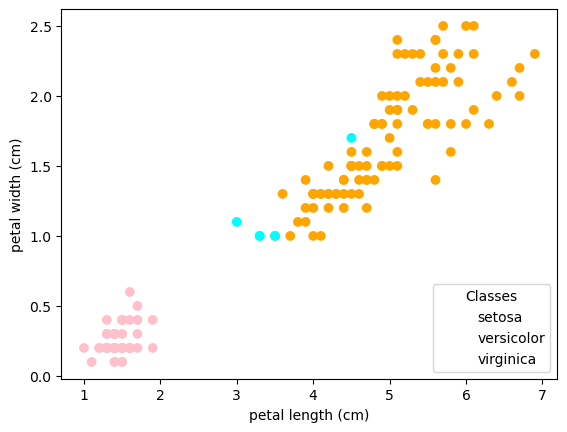

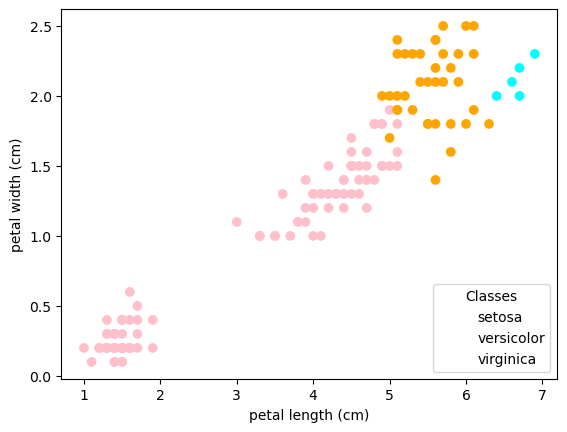

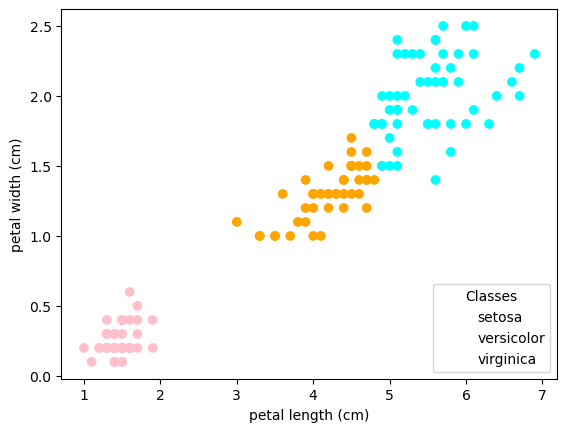

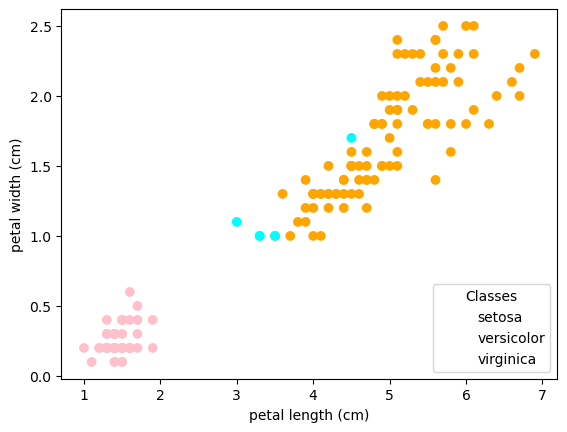

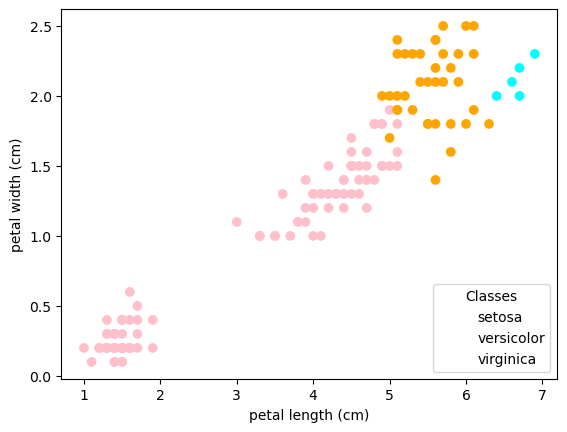

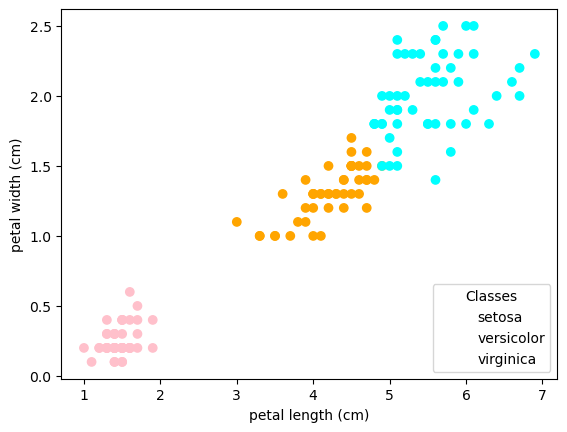

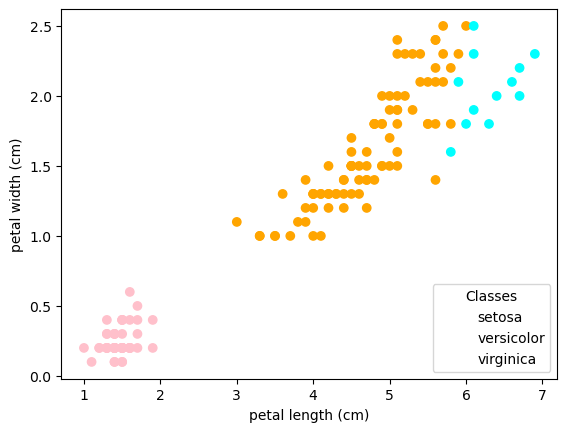

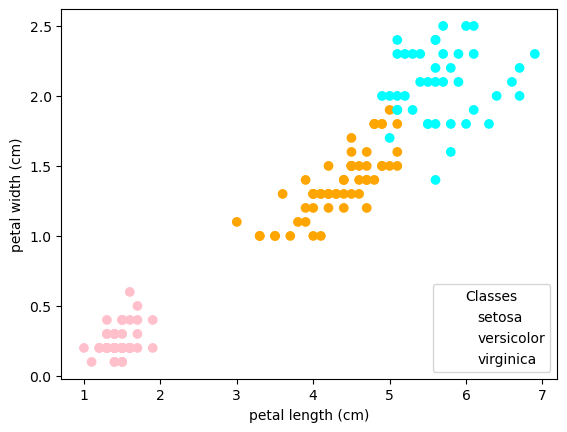

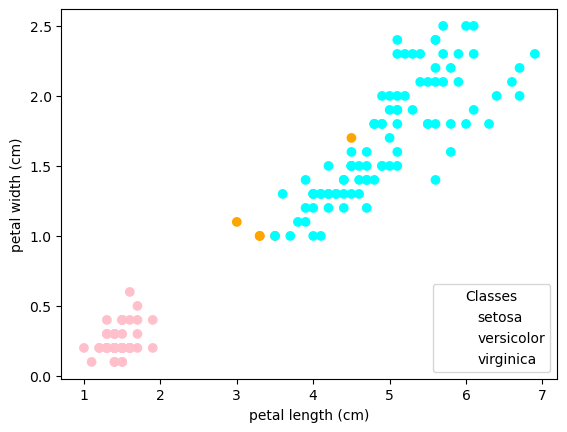

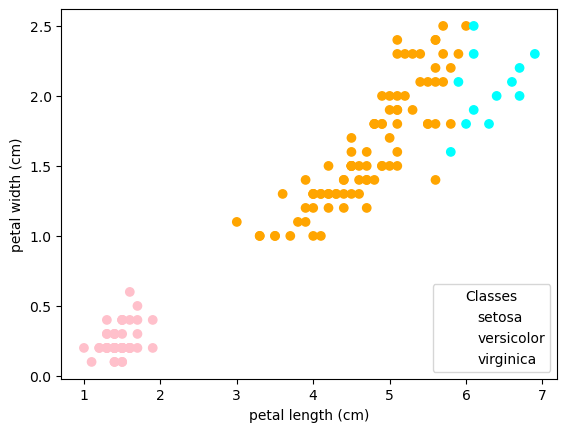

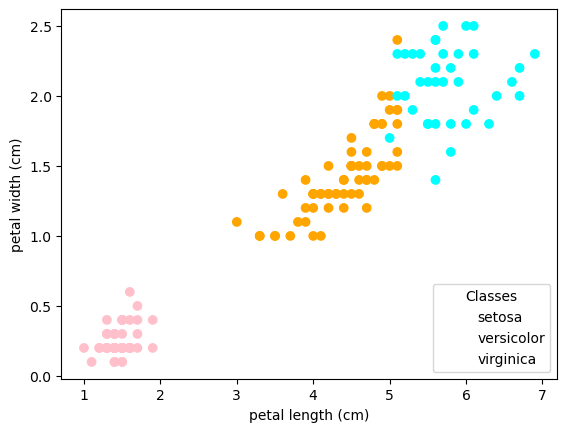

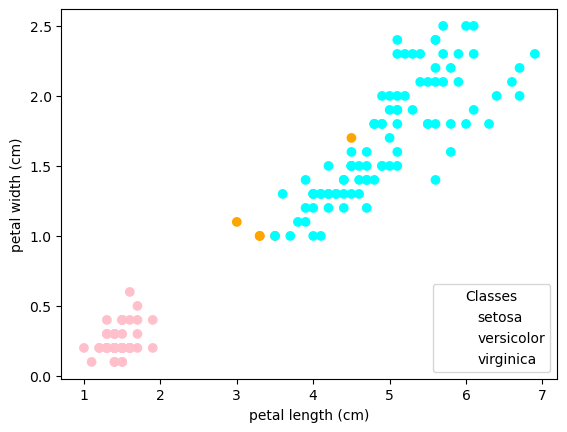

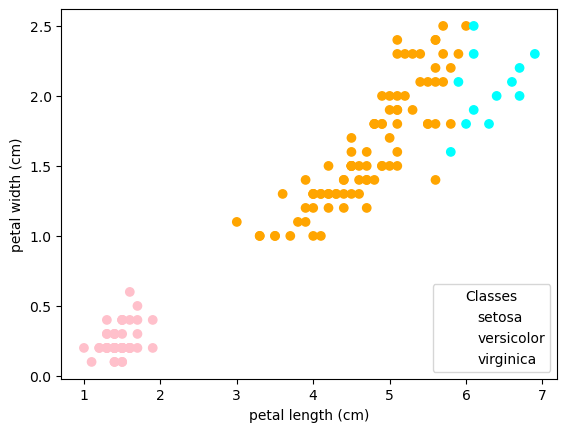

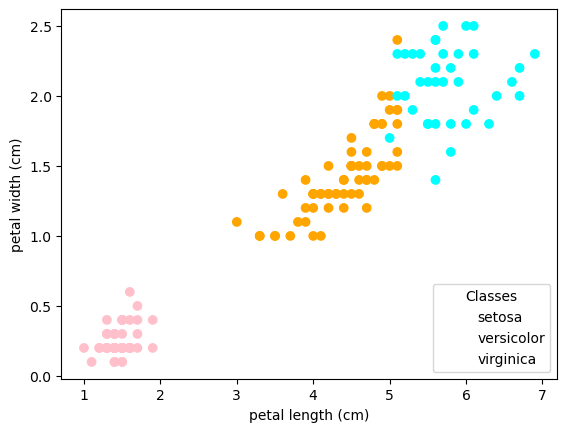

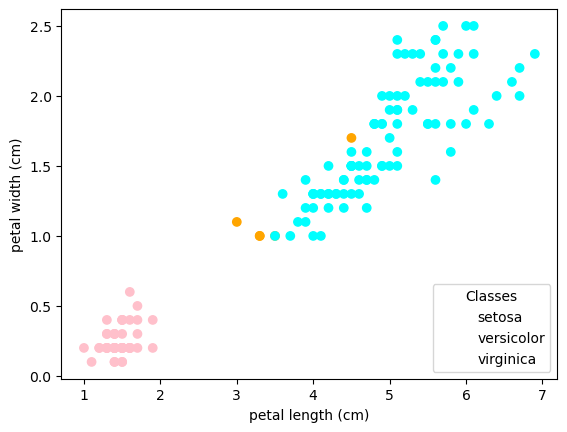

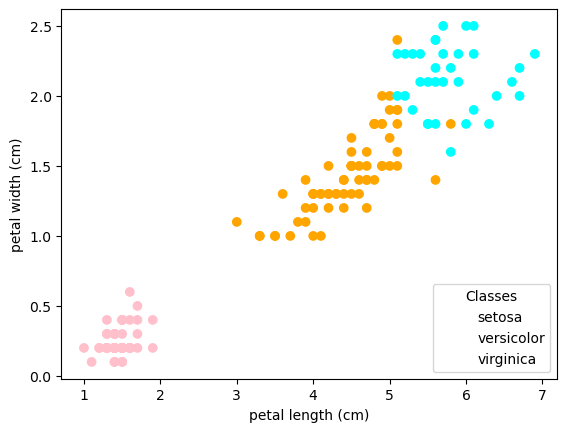

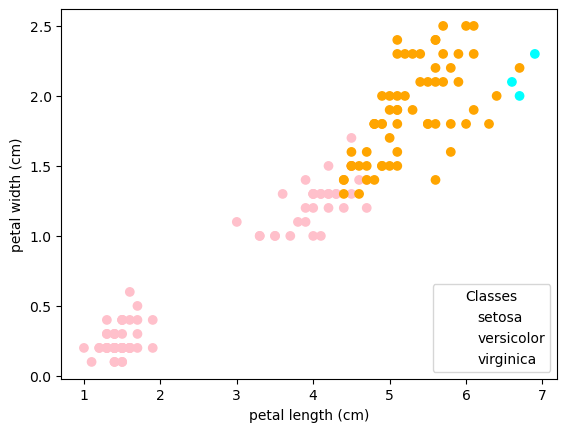

In [52]:
for index in range(len(list_result_clusters)):

    data_x = []
    feature_x = 2
    data_y = []
    feature_y = 3
    target = []

    for cluster, array_points in list_result_clusters[index][3].items():
        for point in array_points:
            data_x.append(point[feature_x])
            data_y.append(point[feature_y])
            target.append(cluster)

    data_x = np.array(data_x)
    data_y = np.array(data_y)
    target = np.array(target)

    name = "iris_2D_B_" + str(list_result_clusters[index][0]) + "_T_" + str(list_result_clusters[index][1]) + "_L_" + str(list_result_clusters[index][2]) + ".jpg"

    plot2D_iris(data_x = data_x, name_x = iris.feature_names[feature_x], data_y = data_y, name_y = iris.feature_names[feature_y],
                target = target, colors_on = True, predict_on = True, name_image = name)

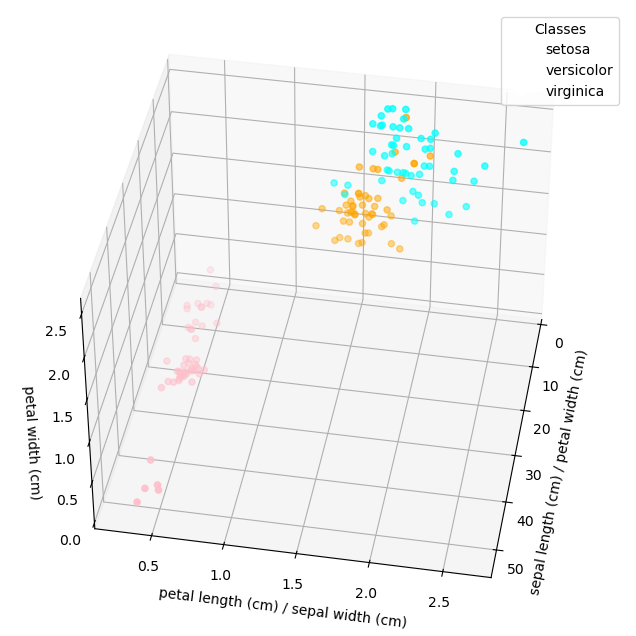

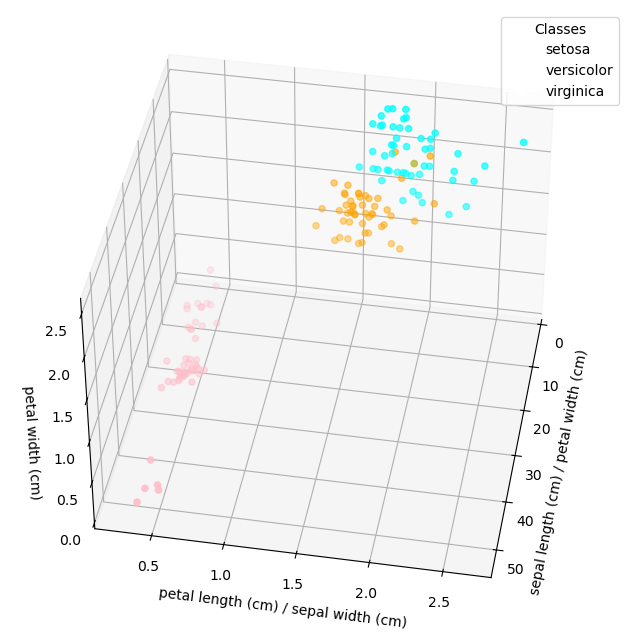

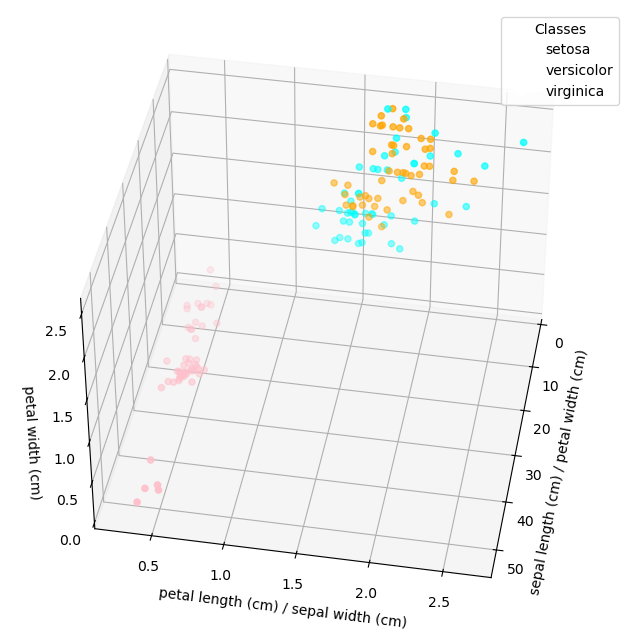

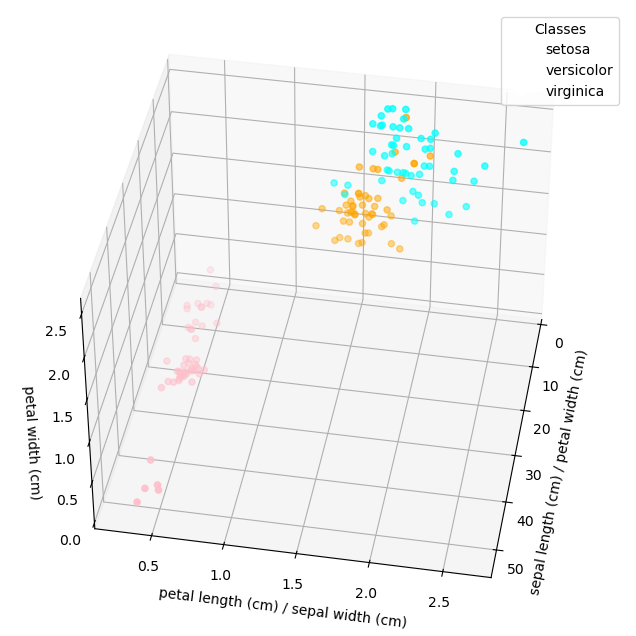

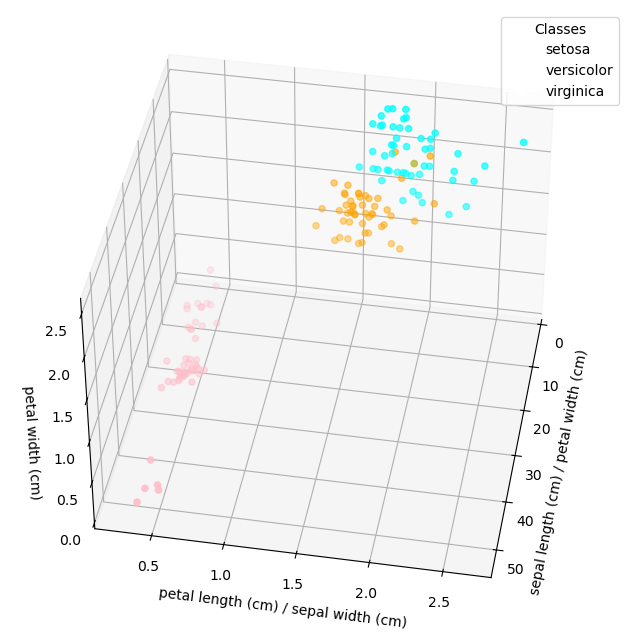

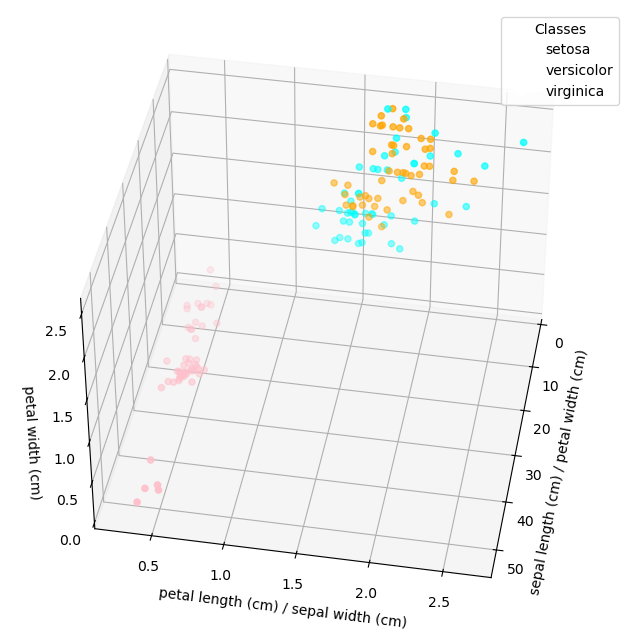

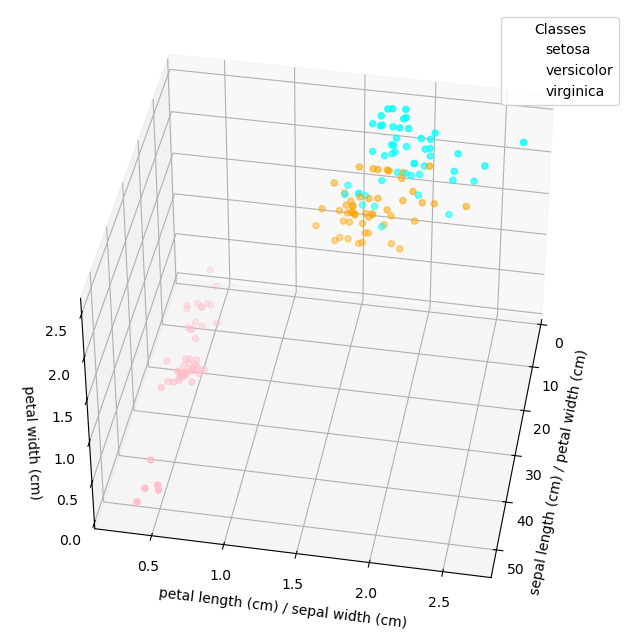

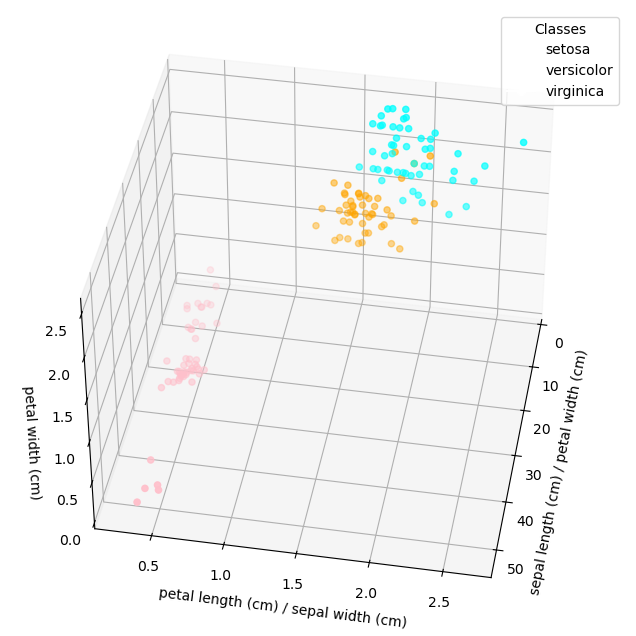

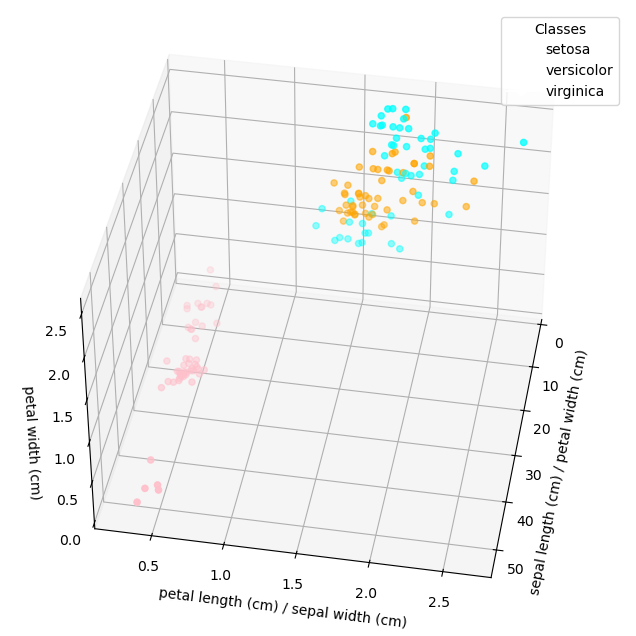

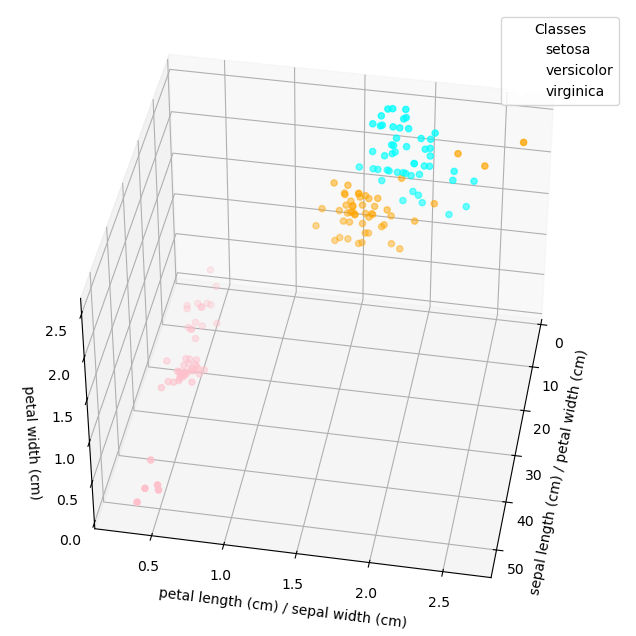

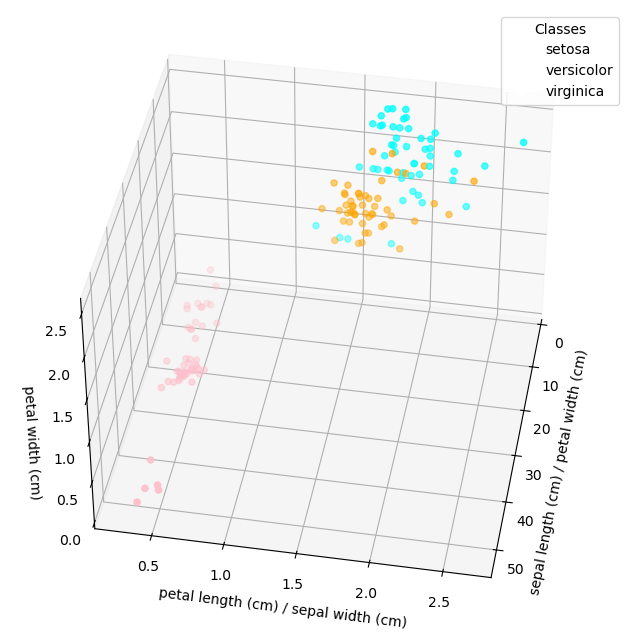

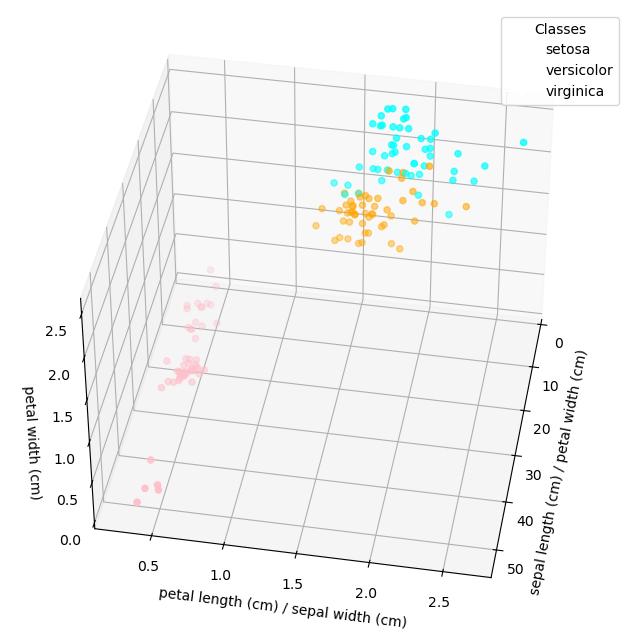

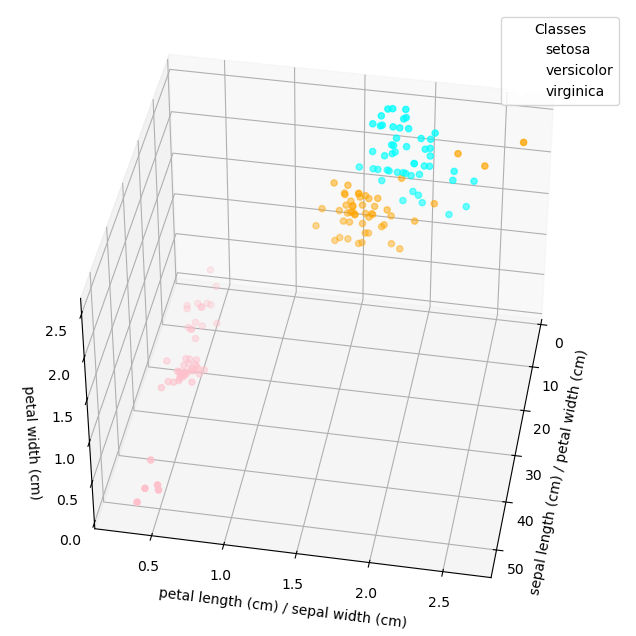

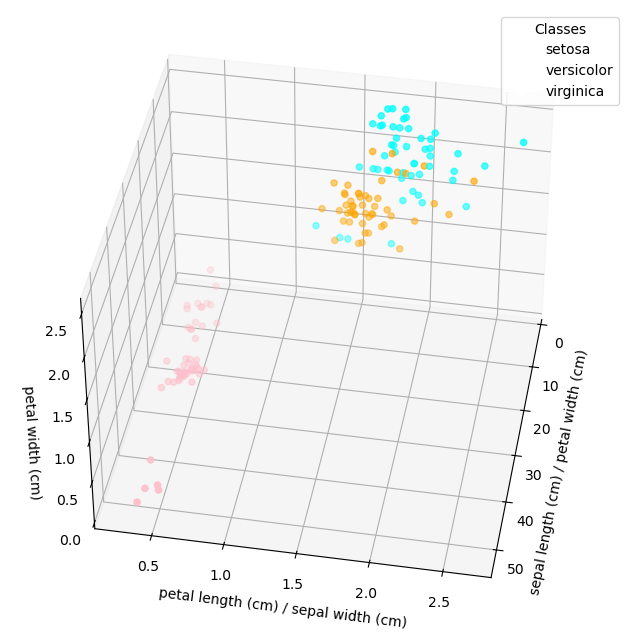

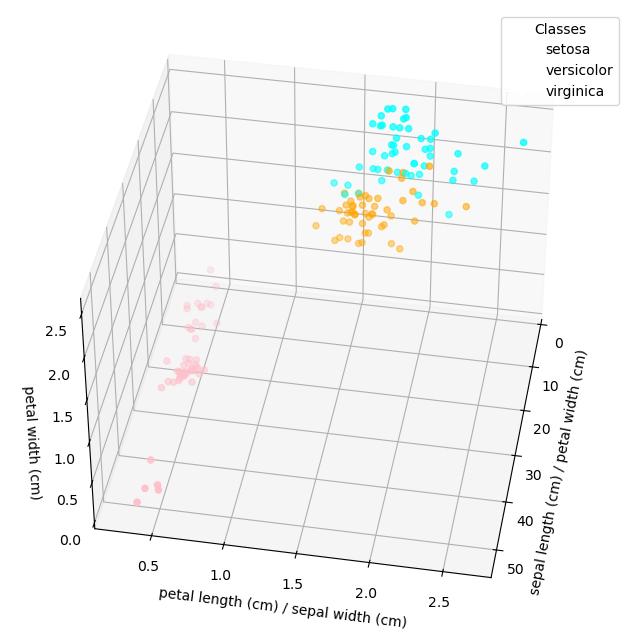

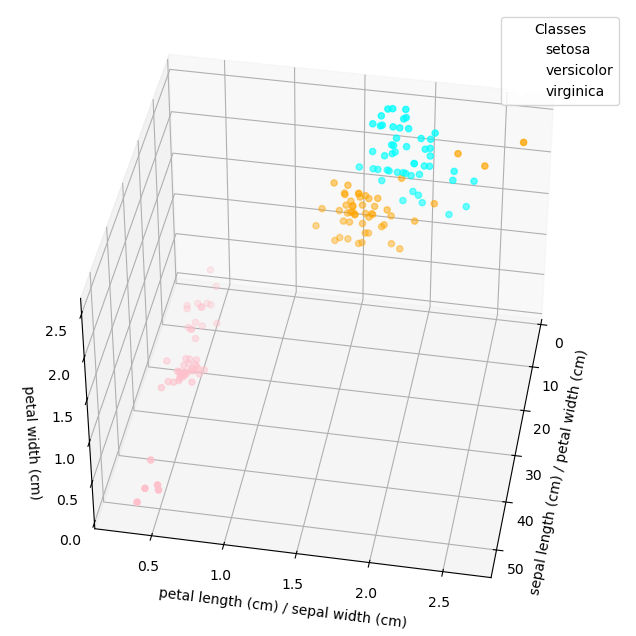

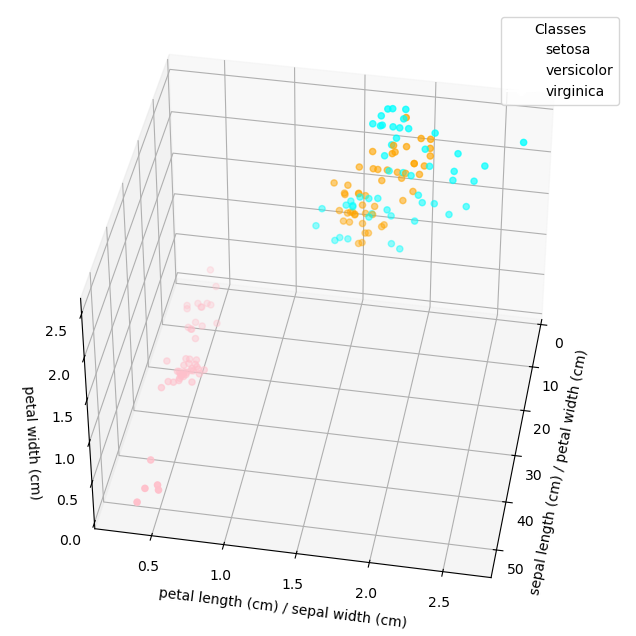

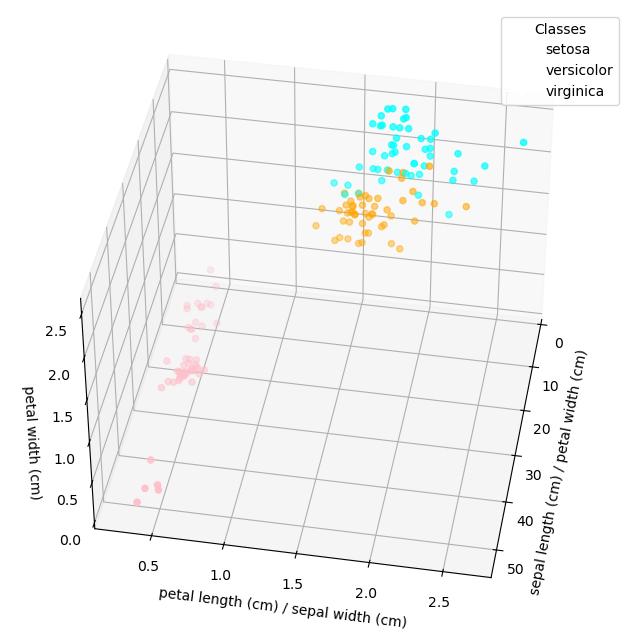

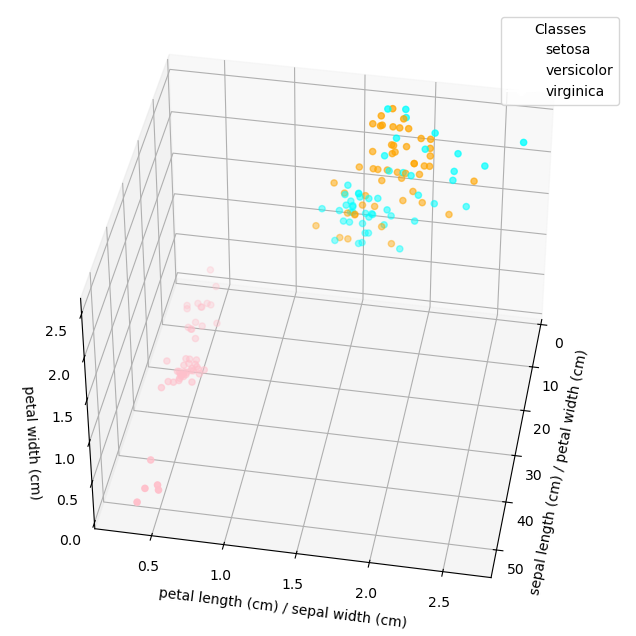

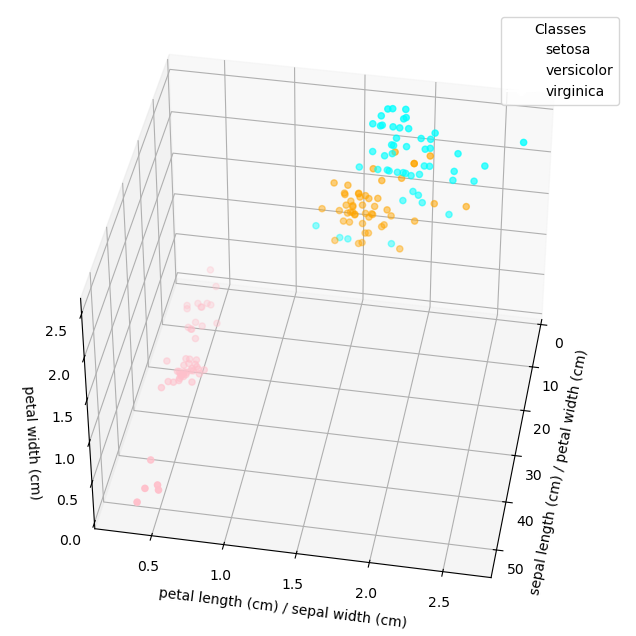

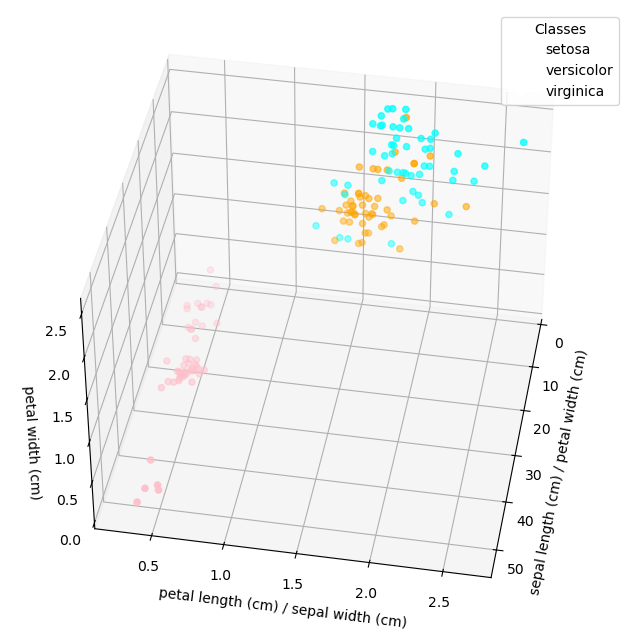

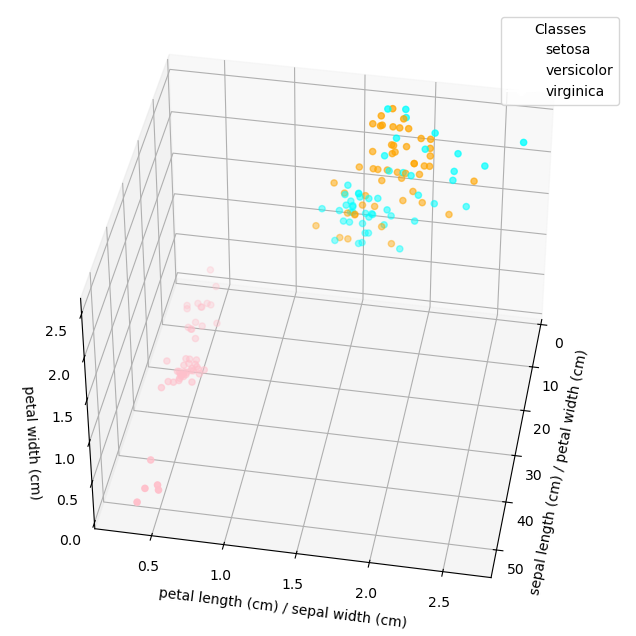

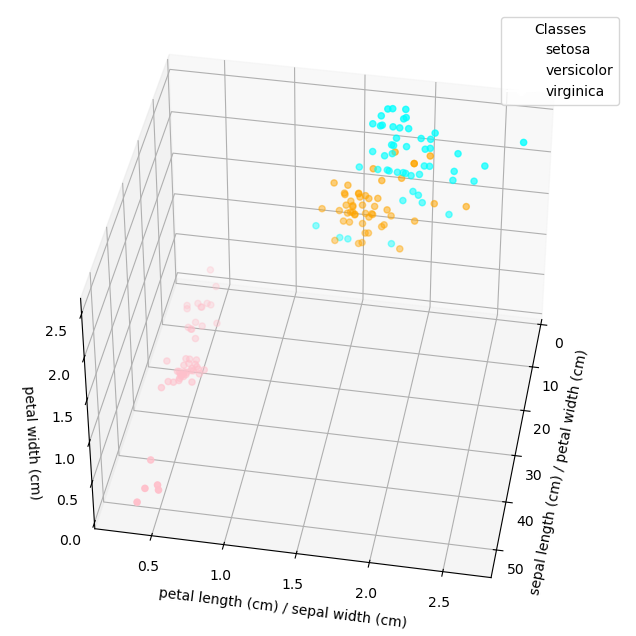

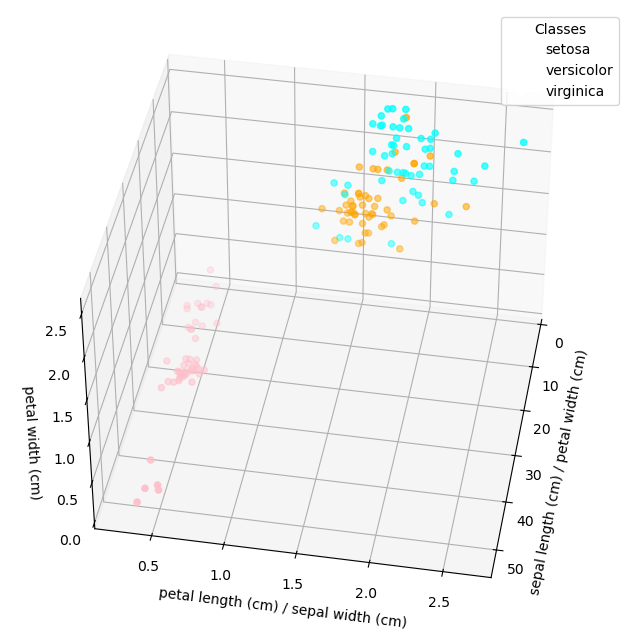

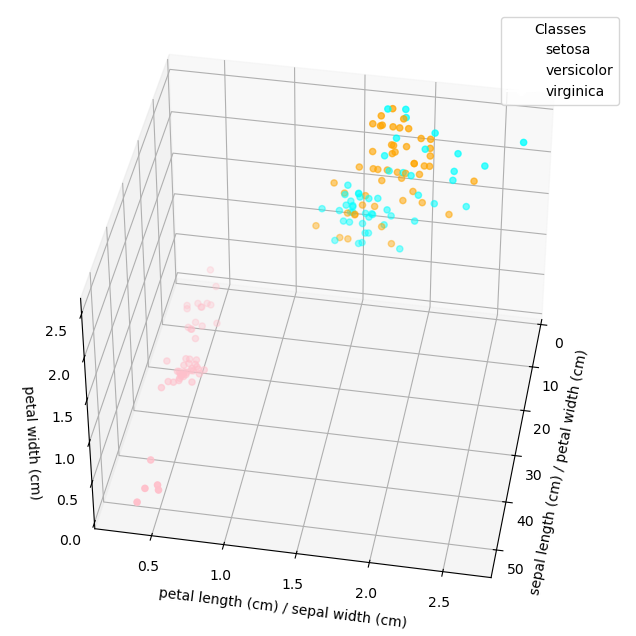

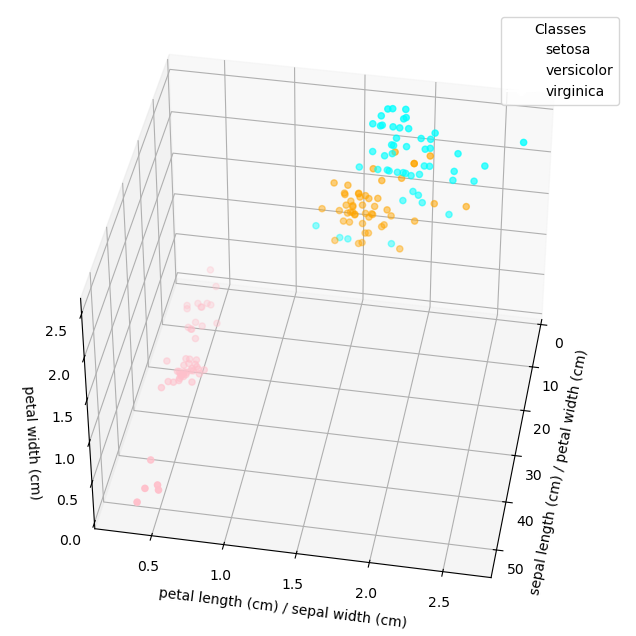

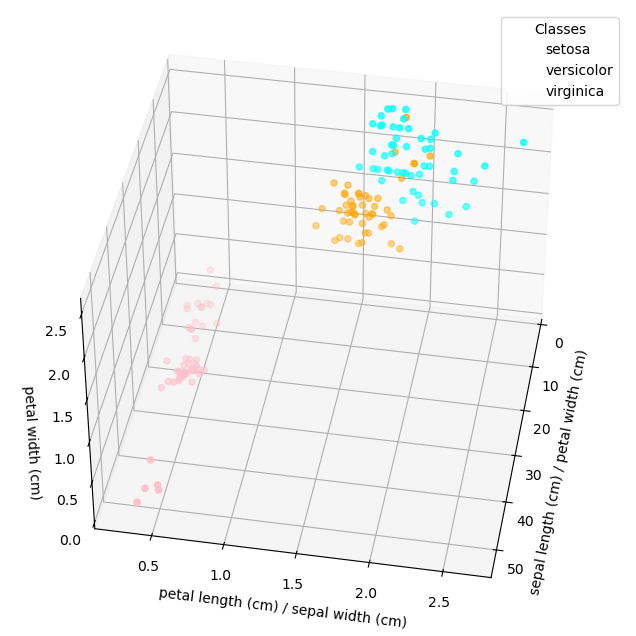

In [53]:
for index in range(len(list_result_clusters)):

    data_x_num = []
    feature_x_num = 0
    data_x_den = []
    feature_x_den = 3

    data_y_num = []
    feature_y_num = 2
    data_y_den = []
    feature_y_den = 1

    data_z = []
    feature_z = 3

    target = []

    for cluster, array_points in list_result_clusters[index][3].items():
        for point in array_points:
            data_x_num.append(point[feature_x_num])
            data_x_den.append(point[feature_x_den])
            data_y_num.append(point[feature_y_num])
            data_y_den.append(point[feature_y_den])
            data_z.append(point[feature_z])
            target.append(cluster)

    data_x_num = np.array(data_x_num)
    data_x_den = np.array(data_x_den)
    data_y_num = np.array(data_y_num)
    data_y_den = np.array(data_y_den)
    data_z = np.array(data_z)
    target = np.array(target)

    name = "iris_3D_B_" + str(list_result_clusters[index][0]) + "_T_" + str(list_result_clusters[index][1]) + "_L_" + str(list_result_clusters[index][2]) + ".jpg"

    plot3D_iris(data_x_num = data_x_num, name_x_num = iris.feature_names[feature_x_num], data_x_den = data_x_den, name_x_den = iris.feature_names[feature_x_den], 
                data_y_num = data_y_num, name_y_num = iris.feature_names[feature_y_num], data_y_den = data_y_den, name_y_den = iris.feature_names[feature_y_den],
                data_z = data_z, name_z = iris.feature_names[feature_z], target = iris.target, colors_on = True, predict_on = True, name_image = name)

### Phase 4

I implemented the optional Phase 4 but I did not collect the data. If you want to run, just uncomment all the code that follows in this section and, in case, modify the parameters  `num_iterations ` and  `index_result_clusters`.

**Caveat**: some minor changes need to be made to store the data you need in a variable. The code I wrote just saves images.

In [60]:
# #
# # Phase 4: Cluster Refining
# #

# # Use the centroids produced by Phase 3 as seeds and redistribute the datapoints to the closest seed

# num_iterations = 2 # TOSET
# index_result_clusters = 0 # TOSET

# name2D = "iris_2D_numIterations_" + str(num_iterations) + "_B_" + str(list_result_clusters[index_result_clusters][0]) + "_T_" + str(list_result_clusters[index_result_clusters][1]) + "_L_" + str(list_result_clusters[index_result_clusters][2]) + ".jpg"
# name3D = "iris_3D_numIterations_" + str(num_iterations) + "_B_" + str(list_result_clusters[index_result_clusters][0]) + "_T_" + str(list_result_clusters[index_result_clusters][1]) + "_L_" + str(list_result_clusters[index_result_clusters][2]) + ".jpg"

# new_result_clusters = side_methods.redistribute_datapoints(list_result_clusters[index_result_clusters][3], num_iterations)

Get and save the images in 2D and 3D:

In [61]:
# data_x = []
# feature_x = 2
# data_y = []
# feature_y = 3
# target = []

# for cluster, array_points in new_result_clusters.items():
#     for point in array_points:
#         data_x.append(point[feature_x])
#         data_y.append(point[feature_y])
#         target.append(cluster)

# data_x = np.array(data_x)
# data_y = np.array(data_y)
# target = np.array(target)

# plot2D_iris(data_x = data_x, name_x = iris.feature_names[feature_x], data_y = data_y, name_y = iris.feature_names[feature_y],
#             target = target, colors_on = True, predict_on = True, name_image = name2D)

In [62]:
# data_x_num = []
# feature_x_num = 0
# data_x_den = []
# feature_x_den = 3

# data_y_num = []
# feature_y_num = 2
# data_y_den = []
# feature_y_den = 1

# data_z = []
# feature_z = 3

# target = []

# for cluster, array_points in new_result_clusters.items():
#     for point in array_points:
#         data_x_num.append(point[feature_x_num])
#         data_x_den.append(point[feature_x_den])
#         data_y_num.append(point[feature_y_num])
#         data_y_den.append(point[feature_y_den])
#         data_z.append(point[feature_z])
#         target.append(cluster)

# data_x_num = np.array(data_x_num)
# data_x_den = np.array(data_x_den)
# data_y_num = np.array(data_y_num)
# data_y_den = np.array(data_y_den)
# data_z = np.array(data_z)
# target = np.array(target)

# plot3D_iris(data_x_num = data_x_num, name_x_num = iris.feature_names[feature_x_num], data_x_den = data_x_den, name_x_den = iris.feature_names[feature_x_den], 
#             data_y_num = data_y_num, name_y_num = iris.feature_names[feature_y_num], data_y_den = data_y_den, name_y_den = iris.feature_names[feature_y_den],
#             data_z = data_z, name_z = iris.feature_names[feature_z], target = iris.target, colors_on = True, predict_on = True, name_image = name3D)

## Comments on the results <a class="anchor" id="comments"></a>

Let's perform a validation of the clustering results obtained and stored in `list_result_clusters` to see which result is expected to be the best. I used the function `sklearn.metrics.silhouette_score`:

In [69]:
from sklearn.metrics import silhouette_score

list_silhouette_scores = []

for result in list_result_clusters:
    cluster_dict = result[3]
    
    all_datapoints = np.vstack(list(cluster_dict.values()))
    all_labels = np.concatenate([np.full(len(v), k) for k, v in cluster_dict.items()])

    silhouette_avg = silhouette_score(all_datapoints, all_labels)

    list_silhouette_scores.append(silhouette_avg)


In [89]:
print("\nThe list of the scores is: ")
print(list_silhouette_scores)


The list of the scores is: 
[0.5339142443209505, 0.5287410448688536, 0.5335352551488629, 0.5339142443209505, 0.5287410448688536, 0.5335352551488629, 0.5064357356205675, 0.5340213263943498, 0.47461975734201367, 0.5143429831424813, 0.46339551175371024, 0.23812118187615258, 0.5143429831424813, 0.46339551175371024, 0.23812118187615258, 0.5143429831424813, 0.5340213263943498, 0.5310259623236633, 0.46339551175371013, 0.5340213263943498, 0.553537292831998, 0.46339551175371013, 0.5340213263943498, 0.553537292831998, 0.46339551175371013, 0.5480088687396695, 0.3491939469206119]


In [90]:
index_max = list_silhouette_scores.index(max(list_silhouette_scores))
print("Index of the element with the highest silhouette score is: " + str(index_max))
print("The silhouette score is: " + str(list_silhouette_scores[index_max]))
print("The parameters are: ")
print(list_trees[index_max])

Index of the element with the highest silhouette score is: 20
The silhouette score is: 0.553537292831998
The parameters are: 
[4, 0.01, 4, <CFTree_methods.CFTree object at 0x0000019D525175F0>]


One can spot just looking at the image that the result given by this validation is not really good. On the other hand, many scores in the `list_silhouette_scores` are quite near to each other. For example, taking the index equal to $12$ we have:

In [91]:
index = 12
print("Index of the element is: " + str(index))
print("The silhouette score is: " + str(list_silhouette_scores[index]))
print("The parameters are: ")
print(list_trees[index])

Index of the element is: 12
The silhouette score is: 0.5143429831424813
The parameters are: 
[3, 0.05, 2, <CFTree_methods.CFTree object at 0x0000019D532D9E50>]


and the clustering appears nicer.

## Possible improvements <a class="anchor" id="improvements"></a>

Many aspects can still be investigated or deepened. First of all, since a set of silhouette scores are quite close to each other, a good idea would be to try with different validation methods such as the F-ratio variance test or the mean squared error. With the `iris` dataset I have the ground truth, so I may also compare the results that I got with the real clusters.

The specific implementation of the BIRCH algorithm may also be tested with other datasets.

Some other possible improvements in my implementation:

- implement the "merging refinement" mentioned in the section "4.2 Insertion into a CF Tree"

- implementing the "Phase 1 revisited" mentioned in the section "5.1 Phase 1 Revisited"

- better use of memory (e.g., deleting things that are no more useful, using references rather than deep copies,...)

- try to use difference distances (more distances are proposed in the paper). However, in the code I wrote it should be quite easy to add the other choices

- study the time needed for the computations

- compare the performances with other algorithms

